In [1]:
import numpy as np
import matplotlib.pyplot as plt

from energyflow.datasets import qg_jets
from rikabplotlib.plot_utils import newplot, hist_with_outline, stamp
from scipy.optimize import minimize

2024-11-08 03:09:07.813091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [55]:
N_jets = 50000
R = 0.4
X, y = qg_jets.load(N_jets)
E0 = 500

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

def compute_angularity(X, beta = 1):
    return np.sum(X[:,:,0] * np.power((X[:,:,1]**2 + X[:,:,2]**2),(beta/2)) / np.power(R, beta) , axis=1)


x = compute_angularity(X, beta=1)
x = x[x > 0]

In [60]:

# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p

def Uniform(x): 

    return Theta(x) * Theta(1 - x)


def Theta(x):
    return np.where(x > 0, np.ones_like(x), np.zeros_like(x))

def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale


def alpha_s(scale, lambda_qcd = 0.2):
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def calculate_lambda_qcd(alpha0, scale0):

    beta_0 = 11 - 2/3 * 3
    
    return scale0 * np.exp(-1 * (2 * np.pi) / (  beta_0 * alpha0))

def run_alpha(alpha0, scale0, scale1):

    beta_0 = 11 - 2/3 * 3
    alpha = alpha0 / (1 + alpha0* beta_0 / (4 * np.pi) * np.log(scale1**2 / scale0**2))

    # if alpha is above 1 or below 0, set it to 1
    alpha = np.where(alpha > 1, np.ones_like(alpha), alpha)
    alpha = np.where(alpha < 0, np.ones_like(alpha), alpha)


    return alpha


def LO_angularity(lambda_, alpha, beta = 1):


    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)

    # alpha_s_scale = alpha 
    C_F = 4/3
    C_A = 3

    return -np.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)



def df_dx(lambda_, beta = 1):

    lambda_qcd = calculate_lambda_qcd(0.2, E0)
    beta_0 = 11 - 2/3 * 3


    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda

   

def LL_angularity(lambda_, alpha, beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    # alpha_s_scale = alpha
    C_F = 4/3
    C_A = 3

    p = np.nan_to_num(LO_angularity(lambda_, alpha_s_scale, beta) * np.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)) )
    return (p * Theta(lambda_) * Theta(1 - lambda_))



def LL_exact_angularity(lambda_, alpha,  beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = run_alpha(alpha, 91, scale)
    C_F = 4/3
    C_A = 3

    p = np.nan_to_num((LO_angularity(lambda_, alpha_s_scale, beta) + df_dx(lambda_, beta)) * np.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1


# Choice of target
target_p = LO_angularity


def second_order_nuisance_function(f):

    def nuisance_function(param, x = x):

        alpha, theta = param[0], param[1]
        # print(alpha, theta)
        theta_gauss = np.exp(-1 * theta**2 / 2) / np.sqrt(2 * np.pi)

        p = f(x, alpha) * (1 + theta * alpha) * theta_gauss
        # Normalize the probability
        # p = p / np.trapz(p, x)
        

        L =  -2 * np.nansum(np.log(p), axis = -1)
        return L

    return nuisance_function


def profile_likelihood(f, x):

    alphas = np.linspace(0, 1, 1001)
    thetas = np.linspace(-3, 3, 1001)

    nuisance_function = second_order_nuisance_function(f)

    # Minimize the nuisance function for alpha and theta
    minima = minimize(nuisance_function, [0.1, 0], args=(x), bounds=[(0.001, 1), (-3, 3)], tol = 1e-9).x
    
    min_alpha = minima[0]
    min_theta = minima[1]
    min_likelihood = nuisance_function([min_alpha, 0], x)

    # Minimize the nuisance function to get theta for each alpha
    profile_likelihood = []
    for alpha in alphas:

        def profile_function(theta, x = x):
            return nuisance_function([alpha, theta], x) - min_likelihood

        min_theta = minimize(profile_function, min_theta, bounds=[(-3, 3)], tol = 1e-9).x * 0

        profile_likelihood.append(nuisance_function([alpha, min_theta], x) - min_likelihood)

    profile_likelihood = np.array(profile_likelihood)
    return profile_likelihood, alphas, min_alpha, min_theta[0]



    # # Compute the profile likelihood
    # thetas = np.ones_like(alphas) * min_theta
    # profile_likelihood = ([nuisance_function([alphas[i], thetas[i]], x) - min_likelihood for i in range(len(alphas))])
    # profile_likelihood = np.array(profile_likelihood)


    return profile_likelihood, alphas, min_alpha, min_theta
    

    # log_likelihood = -2 * np.sum(np.log(probability), axis=0)

    # # Get the minimum over the alphas and thetas
    # min_index = np.unravel_index(np.argmin(log_likelihood), log_likelihood.shape)
    # log_likelihood_min = log_likelihood[min_index]

    # # Get the profile likelihood at the minimum of thetas
    # profile_likelihood = np.min(log_likelihood, axis=1) - log_likelihood_min
    
    # return profile_likelihood

/tmp/ipykernel_4307/3542762088.py:129: RuntimeWarning: divide by zero encountered in log
  L =  -2 * np.nansum(np.log(p), axis = -1)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[0.119 0.12 ]


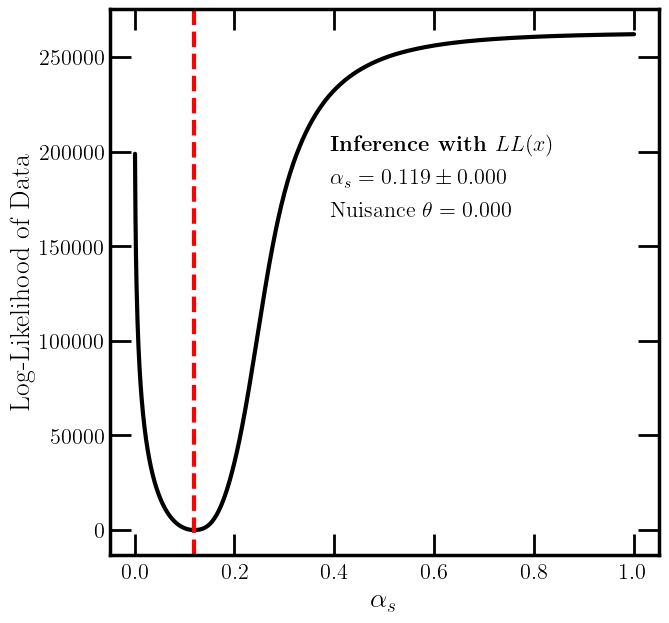

In [61]:
profile_likelihood_LL, alphas, min_alpha, min_theta = profile_likelihood(LL_angularity, x)

# Plotting
alphas = np.linspace(0, 1, 1001)


fig, ax = newplot("full")
ax.plot(alphas, profile_likelihood_LL, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")

# Plot a red line at the minimum
min_alpha = alphas[np.argmin(profile_likelihood_LL)]
plt.axvline(min_alpha, color="red", linestyle="--")

# Calculate where the 1 sigma error is
log_likelihoods = profile_likelihood_LL - np.min(profile_likelihood_LL)
one_sigma = np.where(log_likelihoods < 0.5)[0]
one_sigma = alphas[one_sigma]
diff = np.abs(one_sigma - min_alpha)[0]
print(one_sigma)

plt.axvline(one_sigma[0], color="red", linestyle="--", alpha = 0.25)

line_0 = "Inference with $LL(x)$"
line_1 = rf"$\alpha_s = {min_alpha : .3f}\pm{diff : .3f}$"
line_2 = rf"Nuisance $\theta = {min_theta : .3f}$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize": 16})

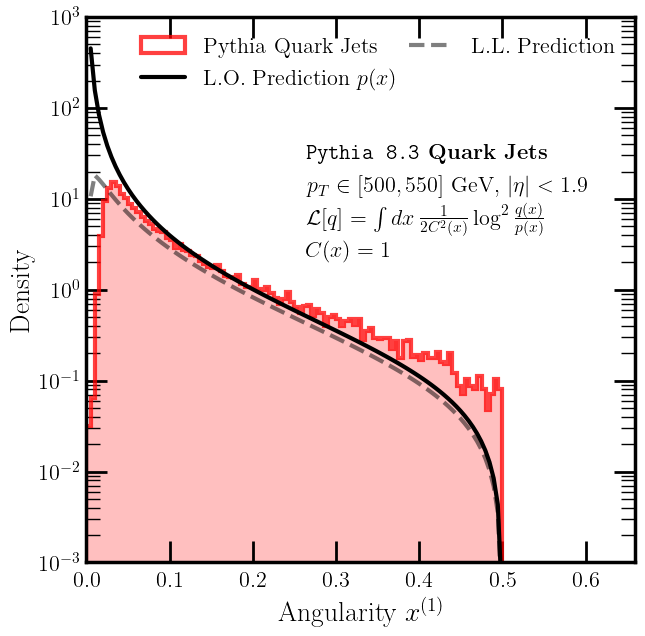

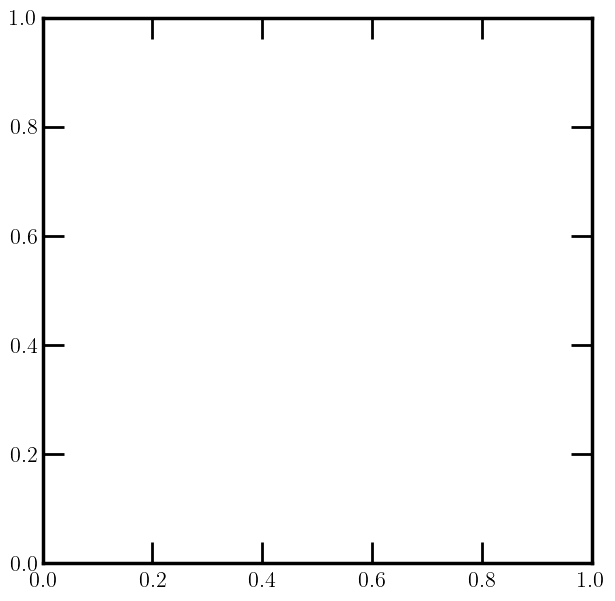

In [62]:
beta = 1
plot_NF = True
plot_exact = True

fig, ax = newplot("full")

normalized_angularity = compute_angularity(X, beta=beta)
normalized_angularity = normalized_angularity[normalized_angularity < 0.5]
# normalized_angularity = normalized_angularity / np.max(normalized_angularity)
np.save("normalized_angularity.npy", normalized_angularity)
bins, edges = np.histogram(normalized_angularity, bins=100, range=(0,1))

errors = np.sqrt(bins)
total_norm = np.sum(bins) * (edges[1] - edges[0])
bins = bins / total_norm
errors = errors / total_norm 



hist_with_outline(ax, normalized_angularity, bins=200, range=(0,1),  density = True, color = "red", label = "Pythia Quark Jets", lw = 3)
lambdas = np.linspace(0.01, 0.999, 100)


alpha_tensor =  0.118
densities = LO_angularity(lambdas, alpha_tensor, beta = beta)
# densities = np.maximum(0, densities)
# normalize angularities so the integral is 1
# densities = densities / np.trapz(densities, lambdas) 
ax.plot(lambdas / 2, densities * 2, color="black", label = "L.O. Prediction $p(x)$")


densities = LL_angularity(lambdas, alpha_tensor, beta = beta)
ax.plot(lambdas / 2, densities * 2, color="black", alpha = 0.5, label = "L.L. Prediction", ls = "--", lw = 3)



# if plot_NF:

#     color = "#6d9eeb"

#     xy = np.load("plotfiles/theta_ys_0.0.npy")

#     plt.plot(xy[0] / 2, xy[1] * 2, color=color, label="$q(x)$ [Numeric NF]", lw=3, alpha = 0.75)


# if plot_exact:

#     color = "#1155cc"
#     # color = "0A7DA4"

#     xy = np.load("plotfiles/exact_theta_ys_0.0.npy")

#     plt.plot(xy[0] / 2, xy[1] * 2, color=color, label="$q(x)$ [Exact Sol.]", lw=3, alpha = 0.75)




plt.xlabel("Angularity $x^{(1)}$")
plt.ylabel("Density")
plt.yscale("log")


line_0 = r"\texttt{Pythia 8.3} Quark Jets"
line_1 = r"$p_T \in [500, 550]$ GeV, $|\eta| < 1.9$"
line_2 = r"$\mathcal{L}[q] = \int dx\, \frac{1}{2C^2(x)}\log^2\frac{q(x)}{p(x)}$"
line_3 = r"$C(x) = 1$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"fontsize": 16})

# # add verticle line at 0.8
# plt.axvline(0.9, color="grey", linestyle="--")

# # to the left of 0.8, fill in the area
# ax.fill_betweenx([0, 1e3], 0, 0.1, color="blue", alpha=0.1)
# ax.fill_betweenx([0, 1e3], 0.4, 0.6, color="blue", alpha=0.1)
# plt.text(0.075, 0.8, "Not well-modeled", color="blue", rotation=90, va="center", ha="center")

# # to the right of 0.8, fill in the area
# ax.fill_betweenx([0, 1e3], 0.1, 0.4, color="red", alpha=0.1)
# plt.text(0.125, 0.8, "Well-modeled", color="red", rotation=90, va="center", ha="center")


plt.ylim(1e-3, 1e3)
plt.xlim(0, 0.66)
plt.legend(frameon=False, loc="upper right", ncol = 2, fontsize=16, columnspacing=0.5)

plt.savefig("angularity_prediction.pdf")

fig, ax = newplot("full")




# Inference with $p$
This is expected to fail! Also, if any event has x = 0, we should get infs, and we do.

/tmp/ipykernel_17216/1262943097.py:9: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.nansum(np.log(densities))


Text(0, 0.5, 'Log-Likelihood of Data')

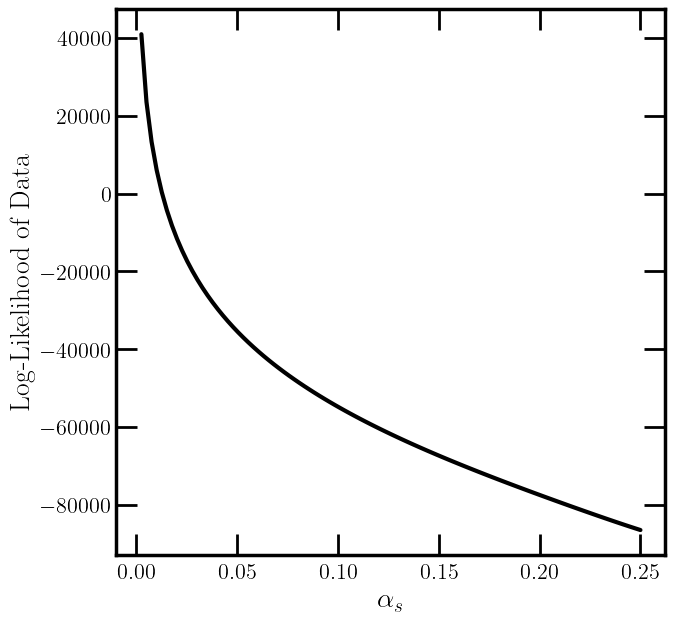

In [ ]:
alphas = np.linspace(0.00, 0.25, 100)

# Evaluate the log-likehood of the data for each alpha
log_likelihoods = []
for alpha in alphas:

    lambdas = np.sort(normalized_angularity)
    densities = np.nan_to_num(LO_angularity(lambdas, alpha, beta = beta))
    log_likelihood = -np.nansum(np.log(densities))
    log_likelihoods.append(log_likelihood)

log_likelihoods = np.array(log_likelihoods)
fig, ax = newplot("full")
ax.plot(alphas, log_likelihoods, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")


/tmp/ipykernel_17216/3871779501.py:14: RuntimeWarning: invalid value encountered in true_divide
  densities = np.nan_to_num(LO_angularity(lambdas, alpha, beta = beta)) / integral


[0.]


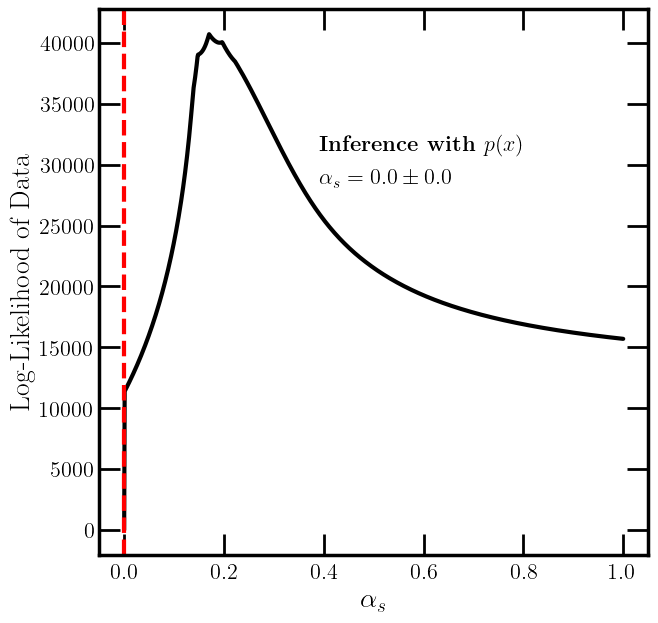

In [ ]:
# Cleaned version where 0's are removed artificially

alphas = np.linspace(0.00, 1, 1000)

# Evaluate the log-likehood of the data for each alpha
log_likelihoods = []
for alpha in alphas:

    lambdas = np.sort(normalized_angularity)
    lambdas = 2 * lambdas[lambdas > 0]

    integral = np.trapz(LO_angularity(lambdas, alpha, beta = beta), lambdas)

    densities = np.nan_to_num(LO_angularity(lambdas, alpha, beta = beta)) / integral
    log_likelihood = -np.nansum(np.log(densities))
    log_likelihoods.append(log_likelihood)

log_likelihoods = np.array(log_likelihoods)
fig, ax = newplot("full")
ax.plot(alphas, log_likelihoods, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")

# Plot a red line at the minimum
min_alpha = alphas[np.argmin(log_likelihoods)]
plt.axvline(min_alpha, color="red", linestyle="--")

# Calculate where the 1 sigma error is
log_likelihoods = log_likelihoods - np.min(log_likelihoods)
one_sigma = np.where(log_likelihoods < 0.5)[0]
one_sigma = alphas[one_sigma]
diff = np.abs(one_sigma - min_alpha)[0]
print(one_sigma)

plt.axvline(one_sigma[0], color="red", linestyle="--", alpha = 0.25)

line_0 = "Inference with $p(x)$"
line_1 = rf"$\alpha_s = {min_alpha}\pm{diff}$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, textops_update={"fontsize": 16})


/tmp/ipykernel_17216/2120191721.py:15: RuntimeWarning: invalid value encountered in true_divide
  densities = np.nan_to_num(LO_angularity(lambdas, alpha, beta = beta)) / integral


-0.0
-1519.0675770147113
-1518.9712737455047
-1518.8752409367285
-1518.7794775381271
-1518.6839825039779
-1518.5887547930777
-1518.4937933687322
-1518.3990971987419
-1518.3046652553912
-1518.210496515434
-1518.1165899600824
-1518.0229445749912
-1517.9295593502468
-1517.8364332803533
-1517.7435653642171
-1517.6509546051368
-1517.5586000107846
-1517.4665005931963
-1517.3746553687547
-1517.2830633581762
-1517.1917235864962
-1517.1006350830553
-1517.0097968814828
-1516.9192080196835
-1516.828867539823
-1516.7387744883117
-1516.64892791579
-1516.5593268771145
-1516.4699704313405
-1516.3808576417084
-1516.2919875756272
-1516.2033593046613
-1516.114971904511
-1516.0268244550025
-1515.9389160400674
-1515.8512457477268
-1515.7638126700813
-1515.6766159032886
-1515.5896545475525
-1515.5029277071037
-1515.416434490185
-1515.3301740090374
-1515.244145379881
-1515.1583477229
-1515.0727801622288
-1514.9874418259317
-1514.9023318459922
-1514.817449358291
-1514.732793502595
-1514.6483634225385
-1514.5

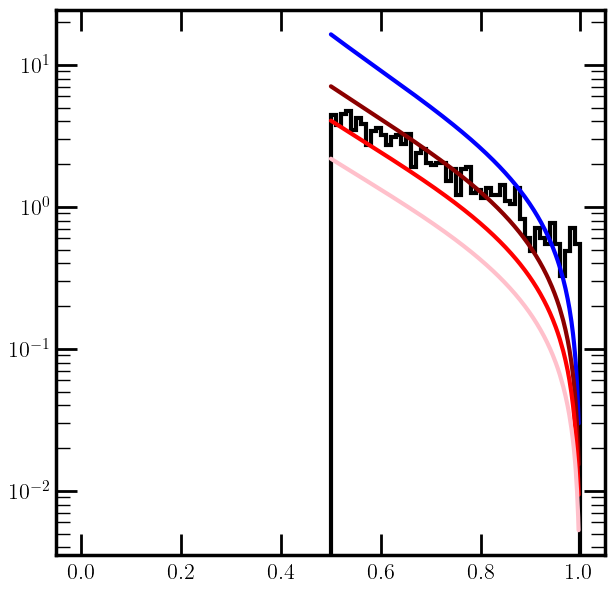

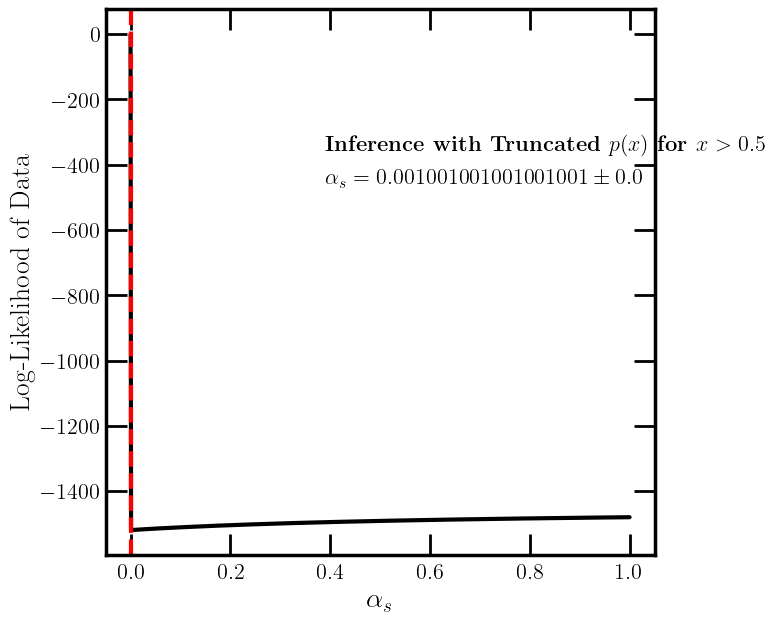

In [ ]:
# Cleaned version where 0's are removed artificially

alphas = np.linspace(0.00, 1, 1000)

# Evaluate the log-likehood of the data for each alpha
log_likelihoods = []
for alpha in alphas:

    

    lambdas = np.sort(normalized_angularity)
    lambdas = 2 * lambdas[lambdas > 0.25]
    num_points = len(lambdas) / len(normalized_angularity)
    integral = np.trapz(LO_angularity(lambdas, alpha, beta = beta), lambdas)
    densities = np.nan_to_num(LO_angularity(lambdas, alpha, beta = beta)) / integral
    log_likelihood = -np.nansum(np.log(densities))
    log_likelihoods.append(log_likelihood)
    print(log_likelihood)

fig, ax = newplot("full")
plt.hist(lambdas, bins=100, range=(0,1), density=True, histtype="step", lw=3, color="black")
plt.plot(lambdas, LO_angularity(lambdas, 1, beta = beta) / num_points, lw=3, color="blue")
plt.plot(lambdas, LO_angularity(lambdas, 2* 0.118, beta = beta) / num_points, lw=3, color="darkred")
plt.plot(lambdas, LO_angularity(lambdas, 0.118, beta = beta) / num_points, lw=3, color="red")
plt.plot(lambdas, LO_angularity(lambdas, 0.5 * 0.118, beta = beta) / num_points, lw=3, color="pink")
plt.yscale("log")


log_likelihoods = np.array(log_likelihoods)
fig, ax = newplot("full")
ax.plot(alphas, log_likelihoods, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")

# Plot a red line at the minimum
min_alpha = alphas[np.argmin(log_likelihoods)]
plt.axvline(min_alpha, color="red", linestyle="--")

# Calculate where the 1 sigma error is
log_likelihoods = log_likelihoods - np.min(log_likelihoods)
one_sigma = np.where(log_likelihoods < 0.5)[0]
one_sigma = alphas[one_sigma]
diff = np.abs(one_sigma - min_alpha)[0]

plt.axvline(one_sigma[0], color="red", linestyle="--", alpha = 0.25)

line_0 = "Inference with Truncated $p(x)$ for $x > 0.5$"
line_1 = rf"$\alpha_s = {min_alpha}\pm{diff}$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, textops_update={"fontsize": 16})


0.0 149292.31
0.001001001001001001 148110.25
0.002002002002002002 146928.4
0.003003003003003003 145746.58
0.004004004004004004 144565.3
0.005005005005005005 143384.52
0.006006006006006006 142204.45
0.007007007007007007 141025.23
0.008008008008008008 139847.08
0.009009009009009009 138670.06
0.01001001001001001 137494.27
0.011011011011011011 136319.94
0.012012012012012012 135147.28
0.013013013013013013 133976.34
0.014014014014014014 132807.31
0.015015015015015015 131640.48
0.016016016016016016 130475.78
0.017017017017017015 129313.36
0.018018018018018018 128153.59
0.01901901901901902 126996.54
0.02002002002002002 125842.25
0.02102102102102102 124690.94
0.022022022022022022 123542.76
0.023023023023023025 122398.04
0.024024024024024024 121256.67
0.025025025025025023 120118.95
0.026026026026026026 118984.89
0.02702702702702703 117854.82
0.028028028028028028 116728.78
0.029029029029029027 115607.08
0.03003003003003003 114489.555
0.031031031031031032 113376.66
0.03203203203203203 112268.37
0.

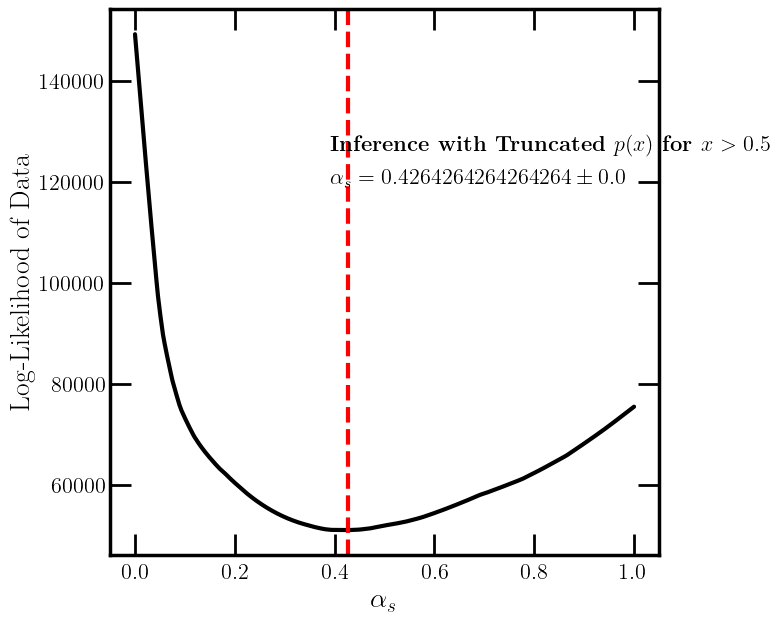

In [ ]:
# Cleaned version where 0's are removed artificially
import zuko
import torch


flow = zuko.flows.BPF(features = 0 + 1, context=1, transforms= 5, hidden_features=(16,16))
flow.load_state_dict(torch.load(f"rikab_model", weights_only=True))
flow.eval()

alphas = np.linspace(0.00, 1, 1000)

# Evaluate the log-likehood of the data for each alpha
log_likelihoods = []
for alpha in alphas:

    # try:
        alpha_tensor = torch.tensor([alpha,], dtype=torch.float32)
        lambdas_np = np.sort(normalized_angularity)
        # print(lambdas_np.shape)
        lambdas = torch.tensor(2 * lambdas_np[lambdas_np > 0], dtype=torch.float32)
        lambdas = lambdas.reshape(-1, 1)
        # print(lambdas.shape)
        # num_points = len(lambdas) / len(normalized_angularity)
        # integral = np.trapz(flow(alpha_tensor).sample(lambdas))
        log_densities = (flow(alpha_tensor).log_prob(lambdas)).detach().numpy()
        # print(log_densities)
        # print(log_densities.shape, lambdas_np.shape)
        # integral = np.trapz(np.exp(log_densities), lambdas_np)
        log_densities = log_densities #- np.log(integral)
        log_likelihood = -np.nansum(log_densities)
        log_likelihoods.append(log_likelihood)
        print(alpha, log_likelihood)
    # except: 
    #     log_likelihoods.append(np.inf)



log_likelihoods = np.array(log_likelihoods)
fig, ax = newplot("full")
ax.plot(alphas, log_likelihoods, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")

# Plot a red line at the minimum
min_alpha = alphas[np.argmin(log_likelihoods)]
plt.axvline(min_alpha, color="red", linestyle="--")

# Calculate where the 1 sigma error is
log_likelihoods = log_likelihoods - np.min(log_likelihoods)
one_sigma = np.where(log_likelihoods < 0.5)[0]
one_sigma = alphas[one_sigma]
diff = np.abs(one_sigma - min_alpha)[0]

plt.axvline(one_sigma[0], color="red", linestyle="--", alpha = 0.25)

line_0 = "Inference with Truncated $p(x)$ for $x > 0.5$"
line_1 = rf"$\alpha_s = {min_alpha}\pm{diff}$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, textops_update={"fontsize": 16})


/tmp/ipykernel_17216/3478244407.py:14: RuntimeWarning: invalid value encountered in true_divide
  densities = np.nan_to_num(LL_angularity(lambdas, alpha, beta = beta)) / integral


0.0 -0.0 [nan nan nan ... nan nan nan] [0.00211981 0.00241889 0.00321857 ... 0.99566656 0.99635837 0.99648996]
0.001 11068.07870022733 [1.82355814e-04 1.89229641e-04 2.25412967e-04 ... 9.04423548e+01
 1.25982316e+02 1.46709463e+02] [0.00211981 0.00241889 0.00321857 ... 0.99566656 0.99635837 0.99648996]
0.002 10823.050492360711 [1.84001292e-04 1.90937216e-04 2.27447498e-04 ... 8.95445810e+01
 1.24379539e+02 1.44644891e+02] [0.00211981 0.00241889 0.00321857 ... 0.99566656 0.99635837 0.99648996]
0.003 10576.521413119935 [1.85678005e-04 1.92677203e-04 2.29520644e-04 ... 8.86368136e+01
 1.22764158e+02 1.42567053e+02] [0.00211981 0.00241889 0.00321857 ... 0.99566656 0.99635837 0.99648996]
0.004 10328.517158871815 [1.87386308e-04 1.94449972e-04 2.31632843e-04 ... 8.77190969e+01
 1.21136442e+02 1.40476399e+02] [0.00211981 0.00241889 0.00321857 ... 0.99566656 0.99635837 0.99648996]
0.005 10079.06483818954 [1.89126550e-04 1.96255885e-04 2.33784528e-04 ... 8.67914853e+01
 1.19496682e+02 1.3837340

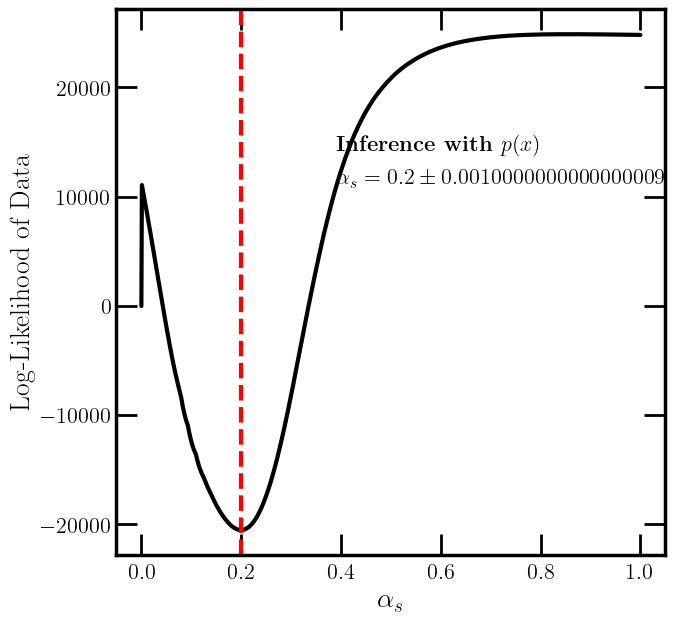

In [ ]:
# Cleaned version where 0's are removed artificially

alphas = np.linspace(0.00, 1, 1001)

# Evaluate the log-likehood of the data for each alpha
log_likelihoods = []
for alpha in alphas:

    lambdas = np.sort(normalized_angularity)
    lambdas = 2 * lambdas[lambdas > 0]

    integral = np.trapz(LL_angularity(lambdas, alpha, beta = beta), lambdas)

    densities = np.nan_to_num(LL_angularity(lambdas, alpha, beta = beta)) / integral
    log_likelihood = -np.nansum(np.log(densities))

    log_likelihoods.append(log_likelihood)
    print(alpha, log_likelihood, np.sort(densities), lambdas)

log_likelihoods = np.array(log_likelihoods)
fig, ax = newplot("full")
ax.plot(alphas, log_likelihoods, lw=3, color="black")
plt.xlabel(r"$\alpha_s$")
plt.ylabel("Log-Likelihood of Data")

# Plot a red line at the minimum
min_alpha = alphas[np.argmin(log_likelihoods)]
plt.axvline(min_alpha, color="red", linestyle="--")

# Calculate where the 1 sigma error is
log_likelihoods = log_likelihoods - np.min(log_likelihoods)
one_sigma = np.where(log_likelihoods < 0.5)[0]
one_sigma = alphas[one_sigma]
diff = np.abs(one_sigma - min_alpha)[0]
print(one_sigma)

plt.axvline(one_sigma[0], color="red", linestyle="--", alpha = 0.25)

line_0 = "Inference with $p(x)$"
line_1 = rf"$\alpha_s = {min_alpha}\pm{diff}$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, textops_update={"fontsize": 16})


6162.980506189696
1.0
0.0005103962589267965


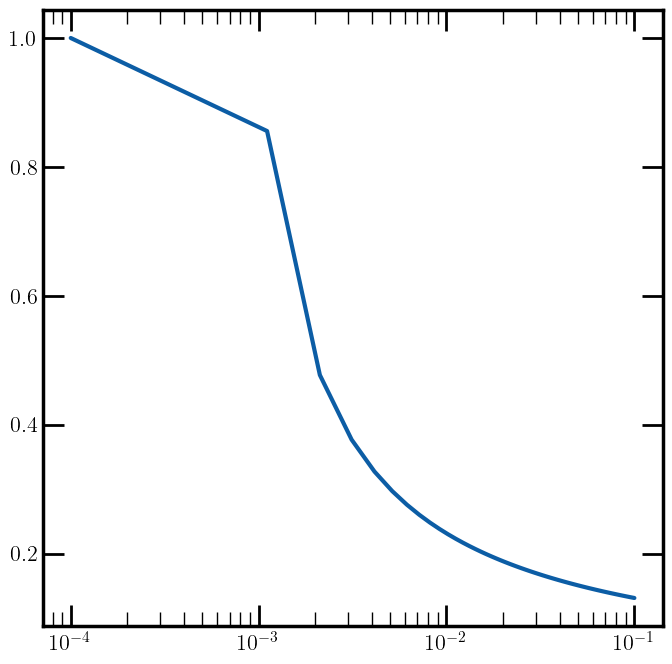

In [ ]:
print(LO_angularity(0.00211981, 0.2))
l = 0.00211981
a = 0.2
print(run_alpha(a, 91, E0 * l))
print(np.exp(-a * np.log(1/l)**2))

# Plot run_alpha as a function of l
lambdas = np.linspace(0.0001, 0.1, 100)
alphas = run_alpha(0.118, 91, E0 * lambdas)
plt.plot(lambdas, alphas)
plt.xscale("log")